In [1]:
%pip install transformers datasets -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 66.7 MB/s eta 0:00:00:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 KB 31.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 64.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.2 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

ds = load_dataset('martingrzzler/sensory-modality-ratings')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/martingrzzler___json/martingrzzler--sensory-modality-ratings-575453efb7a0bd44/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['CONCEPTICON_ID', 'CONCEPTICON_GLOSS', 'ENGLISH', 'ENGLISH_SER_MEAN', 'LINE_IN_SOURCE'],
        num_rows: 1792
    })
})

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

preprocess_df = ds['train'].to_pandas()
preprocess_df['ENGLISH_SER_MEAN'] = scaler.fit_transform(preprocess_df['ENGLISH_SER_MEAN'].to_numpy().reshape(-1, 1))

ds['train'] = ds['train'].from_pandas(preprocess_df)

<Axes: >

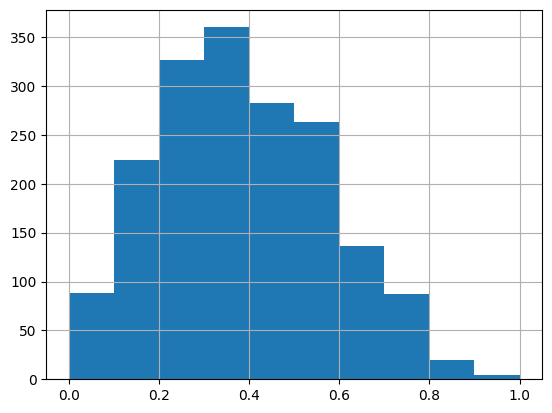

In [5]:
ds['train'].to_pandas()['ENGLISH_SER_MEAN'].hist()

In [6]:
ds = ds.remove_columns(['CONCEPTICON_ID', 'CONCEPTICON_GLOSS', 'LINE_IN_SOURCE'])

In [7]:
ds = ds.rename_column('ENGLISH_SER_MEAN', 'labels')
ds = ds.rename_column('ENGLISH', 'word')

In [8]:
ds

DatasetDict({
    train: Dataset({
        features: ['word', 'labels'],
        num_rows: 1792
    })
})

In [9]:
from transformers import DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

In [11]:
def tokenize(batch):
    return tokenizer(batch['word'], padding='max_length', truncation=True, max_length=10)

In [47]:
tokenized_ds = ds.map(tokenize, batched=True)

Map:   0%|          | 0/1792 [00:00<?, ? examples/s]

In [48]:
tokenize(tokenized_ds['train'][1000])

{'input_ids': [101, 2831, 102, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 0, 0, 0, 0, 0, 0, 0]}

In [49]:
tokenized_ds = tokenized_ds['train'].train_test_split(test_size=0.1, shuffle=True)

In [50]:
tokenized_ds.set_format('torch', columns=['input_ids', 'attention_mask', 'labels', 'word'])

In [51]:
from torch.utils.data import DataLoader

train_loader = DataLoader(tokenized_ds['train'], batch_size=8)
test_loader = DataLoader(tokenized_ds['test'], batch_size=8)

In [17]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [25]:
from transformers import DistilBertForSequenceClassification

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=1)
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [26]:
from torch.optim import Adam

optimizer = Adam(model.parameters(), lr=1e-5)

In [28]:
from transformers import get_scheduler

num_epochs = 20
num_training_steps = len(train_loader) * num_epochs

lr_scheduler = get_scheduler(name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [29]:
from tqdm.auto import tqdm

progress_bar = tqdm(total=num_training_steps)
losses = []

model.train()
for epoch in range(num_epochs):
    for step, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        
        loss = outputs.loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/4040 [00:00<?, ?it/s]

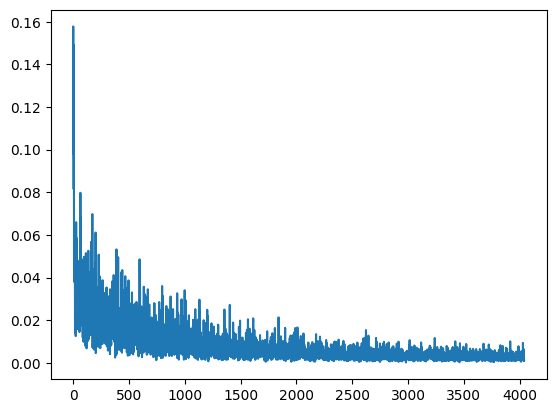

In [30]:
import matplotlib.pyplot as plt

plt.plot(losses)

In [31]:
from scipy.stats import pearsonr

model.eval()

predictions = []
targets = []

for batch in test_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions.extend(logits.squeeze(-1).tolist())
    targets.extend(batch["labels"].tolist())





corr_corf, p_value = pearsonr(predictions, targets)

print(f"Pearson Correlation Coefficient: {corr_corf:.4f}")
print(f"P-value: {p_value:.4f}")

Pearson Correlation Coefficient: 0.7055
P-value: 0.0000


In [32]:
def predict(word):
    inputs = tokenizer(word, return_tensors='pt', padding='max_length', truncation=True, max_length=10)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    return logits.squeeze(-1).tolist()[0]

In [56]:
import random

for i in range(10):
    idx = random.randint(0, len(tokenized_ds['test']))
    print(f"Word: {tokenized_ds['test'][idx]['word']}")
    print(f"Prediction: {predict(tokenized_ds['test'][idx]['word'])}")
    print(f"Ground Truth: {tokenized_ds['test'][idx]['labels']}")
    print()

Word: wall
Prediction: 0.4219787120819092
Ground Truth: 0.4909090995788574

Word: bite
Prediction: 0.4445038437843323
Ground Truth: 0.414000004529953

Word: grass
Prediction: 0.6215035915374756
Ground Truth: 0.5550000071525574

Word: ram
Prediction: 0.525775134563446
Ground Truth: 0.4909090995788574

Word: descend
Prediction: 0.3911648094654083
Ground Truth: 0.3959999978542328

Word: sting
Prediction: 0.4604383111000061
Ground Truth: 0.4418181777000427

Word: envy
Prediction: 0.43302327394485474
Ground Truth: 0.4254545569419861

Word: foot
Prediction: 0.3567005693912506
Ground Truth: 0.34200000762939453

Word: convey
Prediction: 0.19522687792778015
Ground Truth: 0.18000000715255737

Word: law
Prediction: 0.1075415387749672
Ground Truth: 0.13090908527374268



In [64]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [65]:
model.push_to_hub('martingrzzler/distilbert-sensory-modality', create_pr=True)

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/martingrzzler/distilbert-sensory-modality/commit/8800001af5c5d932d5276df13f4b6ef5f0a636d4', commit_message='Upload DistilBertForSequenceClassification', commit_description='', oid='8800001af5c5d932d5276df13f4b6ef5f0a636d4', pr_url='https://huggingface.co/martingrzzler/distilbert-sensory-modality/discussions/1', pr_revision='refs/pr/1', pr_num=1)